In [1]:
import matplotlib.pyplot as plt
import casadi as ca
import numpy as np

In [16]:
# Kinematic Bicycle Model
# https://thomasfermi.github.io/Algorithms-for-Automated-Driving/Control/BicycleModel.html

def vehicle_model(state, control):
    x = state[0] # X position
    y = state[1] # Y position
    theta = state[2] # Heading angle
    v = state[3] # Velocity

    delta = control[0]  # Steering angle
    a = control[1]      # Acceleration

    # Bicycle model ODEs
    dx = v * ca.cos(theta)
    dy = v * ca.sin(theta)
    dtheta = (v * ca.tan(delta)) / 2.5  # Assuming wheelbase of 2.5m
    dv = a

    return ca.vertcat(dx, dy, dtheta, dv)


def rk4(state, u, dt=0.2):
    k1 = dt * vehicle_model(state, u)
    k2 = dt * vehicle_model(state + 0.5 * k1, u)
    k3 = dt * vehicle_model(state + 0.5 * k2, u)
    k4 = dt * vehicle_model(state + k3, u)
    next_state = state + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return next_state

def cost_function(state, control, weight):
    # x = state[0]
    y = state[1]
    # theta = state[2]
    # v = state[3]

    delta = control[0]  
    a = control[1]       

    cost = 0.0

    cost += (weight * y**2) # Penalize deviation from y = 0 : Tracking error
    cost += 0.1 * delta**2 + 0.1 * a**2 # Penalize steering and acceleration : Control effort
    return cost

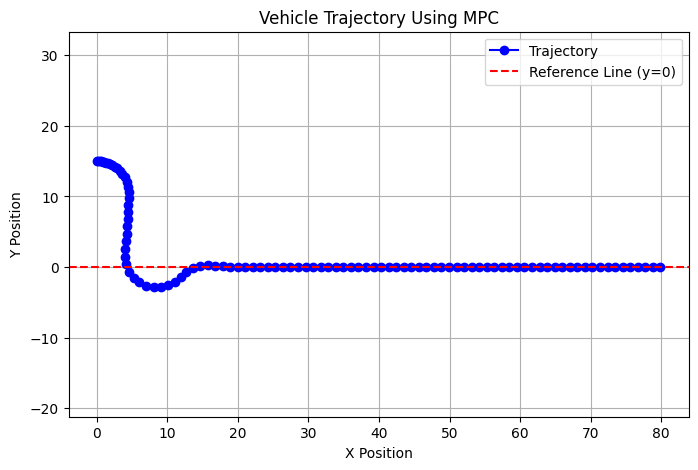

In [21]:
no_states = 4 # [x, y, theta, v]
no_inputs = 2 # [delta, a] (steering angle, acceleration)
prediction_horizon = 4
dt = 0.2
# [
#     [d,a],
#     [d,a]
# ]


# Symbolic state and control vectors
state = ca.MX.sym('state', no_states)
control = ca.MX.sym('control', prediction_horizon, no_inputs)
weight = ca.MX.sym('weight', 1)  # Make weight symbolic

x_sym = state
total_cost = 0.0

for k in range(prediction_horizon):
    u_k = control[k, :]
    total_cost += cost_function(x_sym, u_k, weight)
    x_sym = rk4(x_sym, u_k, dt=dt)

# Defining symbolic cost and gradient functions
cost_fn = ca.Function("cost_fn", [state, control, weight], [total_cost])
grad_fn = ca.Function("grad_fn", [state, control, weight], [ca.gradient(total_cost, control)])
# cost_fn.generate("func.c", {"with_codegen": True})
# Simulate MPC
u = np.zeros((prediction_horizon, no_inputs)) 
x = np.array([0.0, 15.0, 0.0, 1.0])  # Initial state: [x, y, theta, v]    
weight_val = 3.0  # Actual weight value to use in simulation

# Saving trajectory for plotting later
traj_x = [x[0]]
traj_y = [x[1]]

for i in range(100):  # Simulate for 250 iterations
    cost = cost_fn(x, u, weight_val)
    grad = grad_fn(x, u, weight_val)
    u = u - grad * 0.1

    
    # u = u - grad * 0.1

    # Clip controls
    u[:, 1] = np.clip(u[:, 1], -2.0, 2.0)   # acceleration constraints
    u[:, 0] = np.clip(u[:, 0], -0.5, 0.5)   # steering angle constraints

    x = rk4(x, u[0, :], dt=dt)  # Apply the first control
    x = np.array(x.full().flatten())  # Convert CasADi MX to NumPy array

    # Shift control sequence
    u[:-1] = u[1:]
    u[-1] = u[-2]  # Keep last control the same as before

    traj_x.append(x[0])
    traj_y.append(x[1])

    # print(f"Iteration {i+1}/250:\n x: {x}")
    # print(f"Control: {u}\nCost: {cost}\n")

# Plot trajectory
plt.figure(figsize=(8, 5))
plt.plot(traj_x, traj_y, 'bo-', label="Trajectory")
plt.axhline(y=0, color='r', linestyle='--', label="Reference Line (y=0)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vehicle Trajectory Using MPC")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


1. use scipy.optimize (sqp) .. -> convert all the code to neumerical. 
2. in the github repo, make write the exmaple first .. car model example modeled in sympy , rk2 3 4